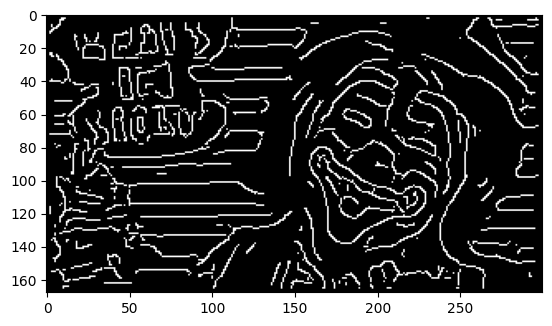

In [1]:
import numpy as np
import matplotlib.pyplot as plt

image = plt.imread("clown.jpeg")

def RGB2Gray(image):
    gray = 0.3*image[:, :, 0] + 0.59*image[:, :, 1] + 0.11*image[:, :, 2]
    return gray

def gauss_kernel(size, stdd=1.5):
 
    kernel_one = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_one[i] = 1 / (np.sqrt(2 * np.pi) * stdd) * np.e ** (-np.power((kernel_one[i]) / stdd, 2) / 2)

    kernel_twod = np.outer(kernel_one.T, kernel_one.T)
 
    kernel_twod *= 1.0 / kernel_twod.max()
 
    return kernel_twod

def convolution(image, kernel):
    rows_image, cols_image = image.shape
    rows_kernel, cols_kernel = kernel.shape
    
    rows_padding = (rows_kernel -1)//2
    cols_padding = (cols_kernel -1)//2
    
    pad_image = np.zeros((rows_image + (2 *rows_padding), cols_image + (2 *cols_padding)))
    out = np.zeros(image.shape)
    
    pad_image[rows_padding:pad_image.shape[0] - rows_padding, cols_padding:pad_image.shape[1] - cols_padding] = image
    
    for row in range(rows_image):
        for col in range(cols_image):
            out[row,col] = np.sum(kernel * pad_image[row:row + rows_kernel, col:col + cols_kernel])
            out[row, col] /= kernel.shape[0] * kernel.shape[1]
    return out

def sobel_filter(image, sobel_filter):
    sobel_x = convolution(image, sobel_filter)
    sobel_y = convolution(image, np.flip(sobel_filter.T, axis=0))
    grad_mag = np.sqrt(np.square(sobel_x) + np.square(sobel_y))
    grad_mag *= 255.0 / grad_mag.max()
    orientation = np.arctan2(sobel_y, sobel_x) * (180 / np.pi) % 180
    return grad_mag, orientation


def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

def threshold(image, thresh_value):
 
    output = np.zeros(image.shape)
 
    strong = 255
    thresh_value = thresh_value
    weak = 0
 
    strong_row, strong_col = np.where(image >= thresh_value)
    weak_row, weak_col = np.where(image < thresh_value)
 
    output[strong_row, strong_col] = strong
    output[weak_row, weak_col] = weak
    return output


k = gauss_kernel(9, stdd=3.0)
image_result = convolution(RGB2Gray(image), k)
sobel_fil = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
img_grad_mag, img_orientation =sobel_filter(image_result, sobel_fil)
img = non_max_suppression(img_grad_mag,img_orientation)
thresh_value = np.median(img_grad_mag)
output = threshold(img, thresh_value)
plt.imshow(output, cmap='gray')